<a href="https://colab.research.google.com/github/melinaem/Portfolio/blob/main/Pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn


# print(data.columns)
# print(data.info())


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
data = pd.read_csv('/content/Housing.csv')
print(data.head())

      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished  


array([[<Axes: title={'center': 'area'}>,
        <Axes: title={'center': 'bedrooms'}>],
       [<Axes: title={'center': 'bathrooms'}>,
        <Axes: title={'center': 'stories'}>],
       [<Axes: title={'center': 'parking'}>,
        <Axes: title={'center': 'price'}>]], dtype=object)

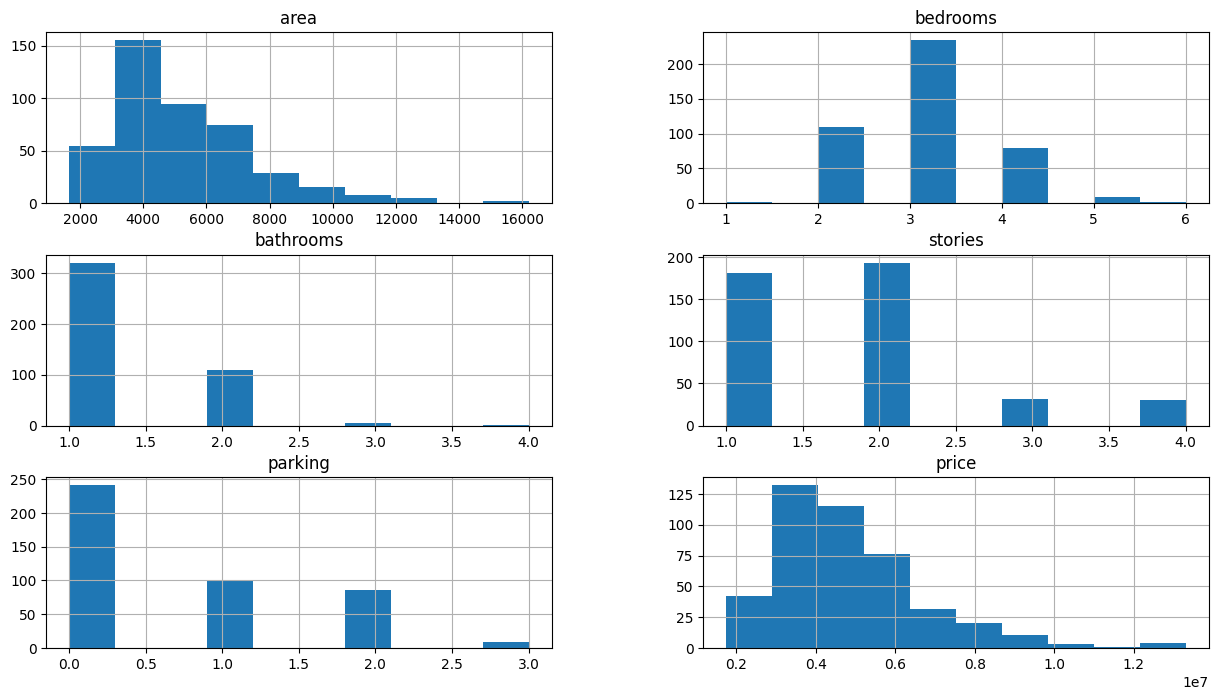

In [11]:
from sklearn.model_selection import train_test_split

X = data.drop(['price'], axis=1)
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

train_data = X_train.join(y_train)
train_data.hist(figsize=(15, 8))

<Axes: >

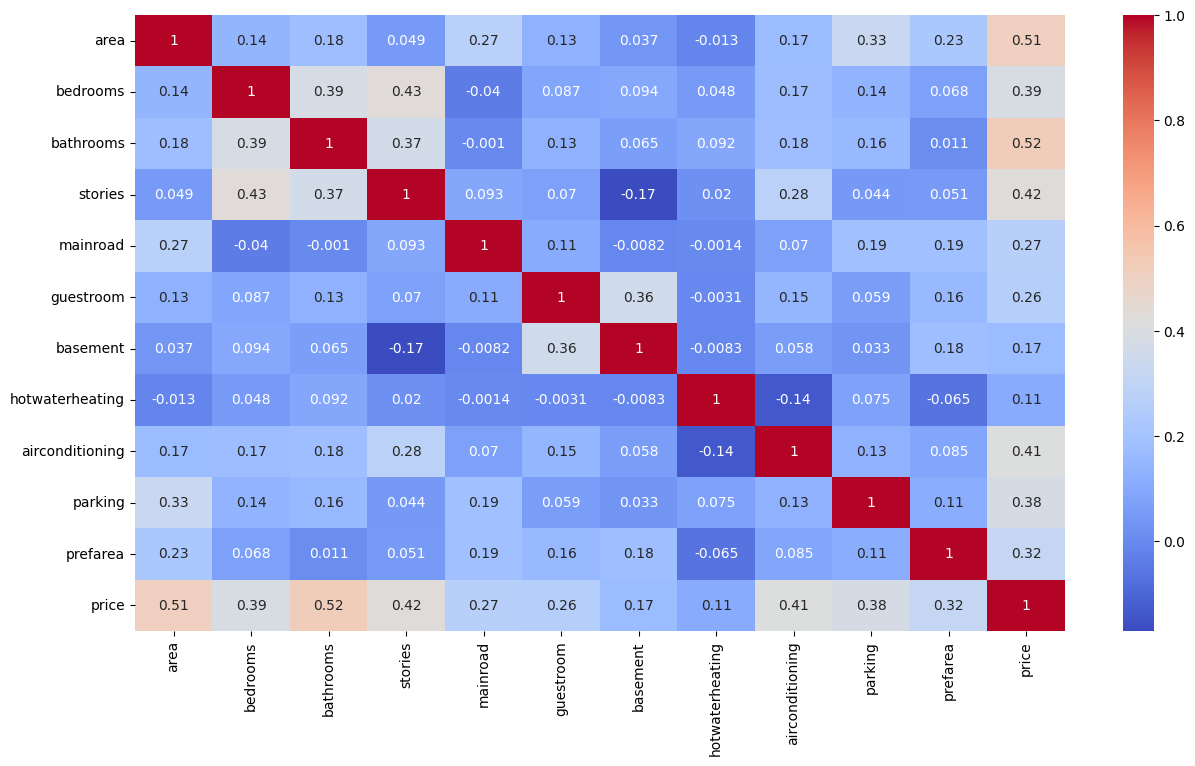

In [21]:
train_data = train_data.apply(lambda col: col.map({'yes': 1, 'no': 0}) if col.isin(['yes', 'no']).all() else col)

plt.figure(figsize=(15, 8))
sns.heatmap(train_data.drop("furnishingstatus", axis=1).corr(), annot=True, cmap='coolwarm')

In [22]:
train_data['area'] = np.log(train_data['area'] + 1)
train_data['stories'] = np.log(train_data['stories'] + 1)
train_data['bathrooms'] = np.log(train_data['bathrooms'] + 1)
train_data['price'] = np.log(train_data['price'] + 1)

array([[<Axes: title={'center': 'area'}>,
        <Axes: title={'center': 'bedrooms'}>,
        <Axes: title={'center': 'bathrooms'}>],
       [<Axes: title={'center': 'stories'}>,
        <Axes: title={'center': 'mainroad'}>,
        <Axes: title={'center': 'guestroom'}>],
       [<Axes: title={'center': 'basement'}>,
        <Axes: title={'center': 'hotwaterheating'}>,
        <Axes: title={'center': 'airconditioning'}>],
       [<Axes: title={'center': 'parking'}>,
        <Axes: title={'center': 'prefarea'}>,
        <Axes: title={'center': 'price'}>]], dtype=object)

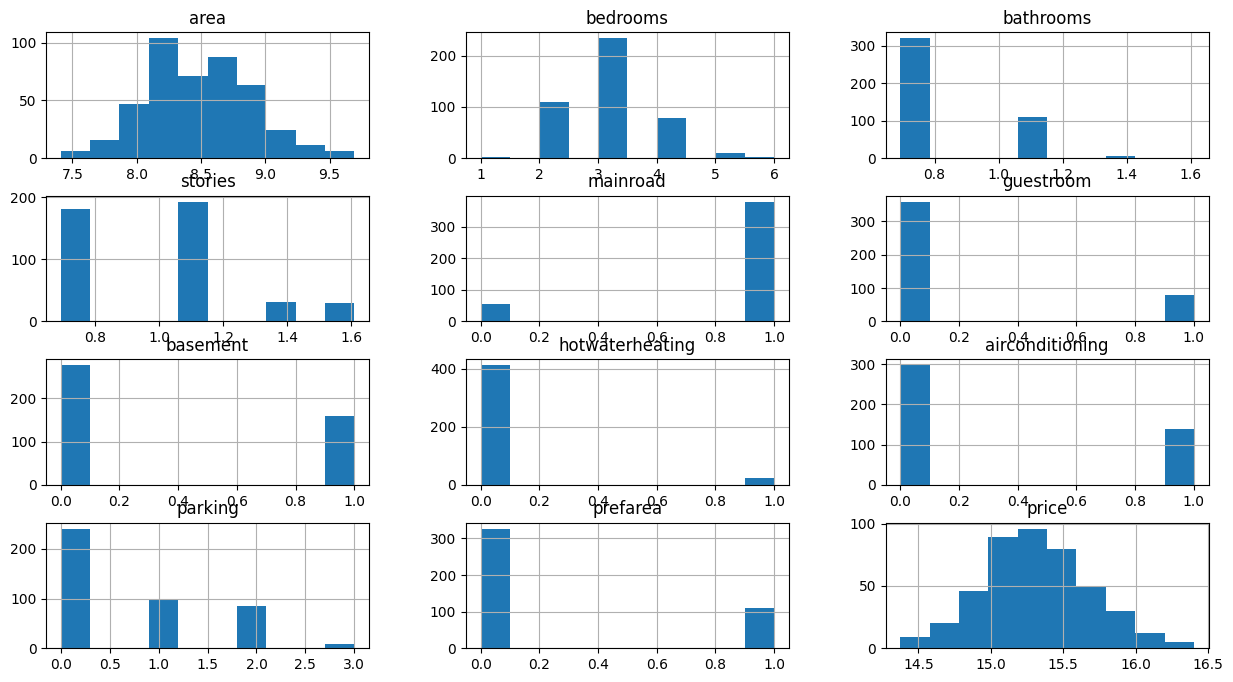

In [24]:
train_data.hist(figsize=(15, 8))

<Axes: xlabel='area', ylabel='price'>

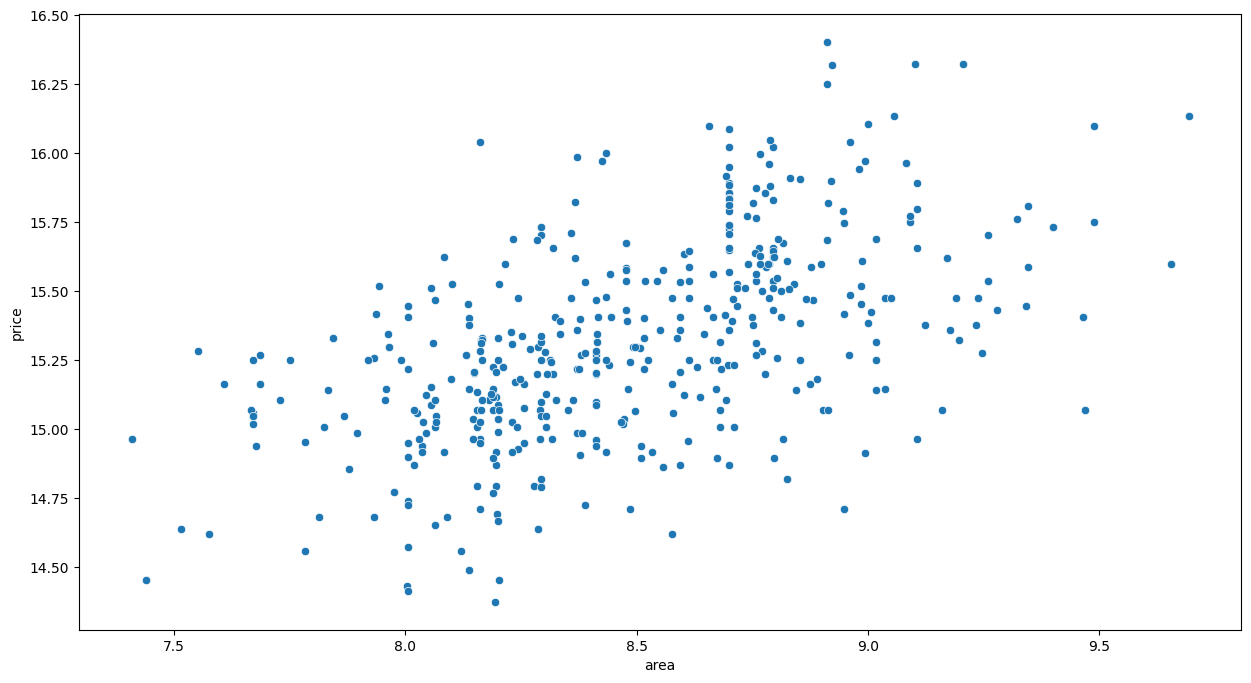

In [31]:
plt.figure(figsize=(15, 8))
sns.scatterplot(x='area', y='price', data=train_data)

In [33]:
train_data['rooms'] = train_data['bedrooms'] + train_data['bathrooms'] + train_data['guestroom'] + train_data['basement']

<Axes: >

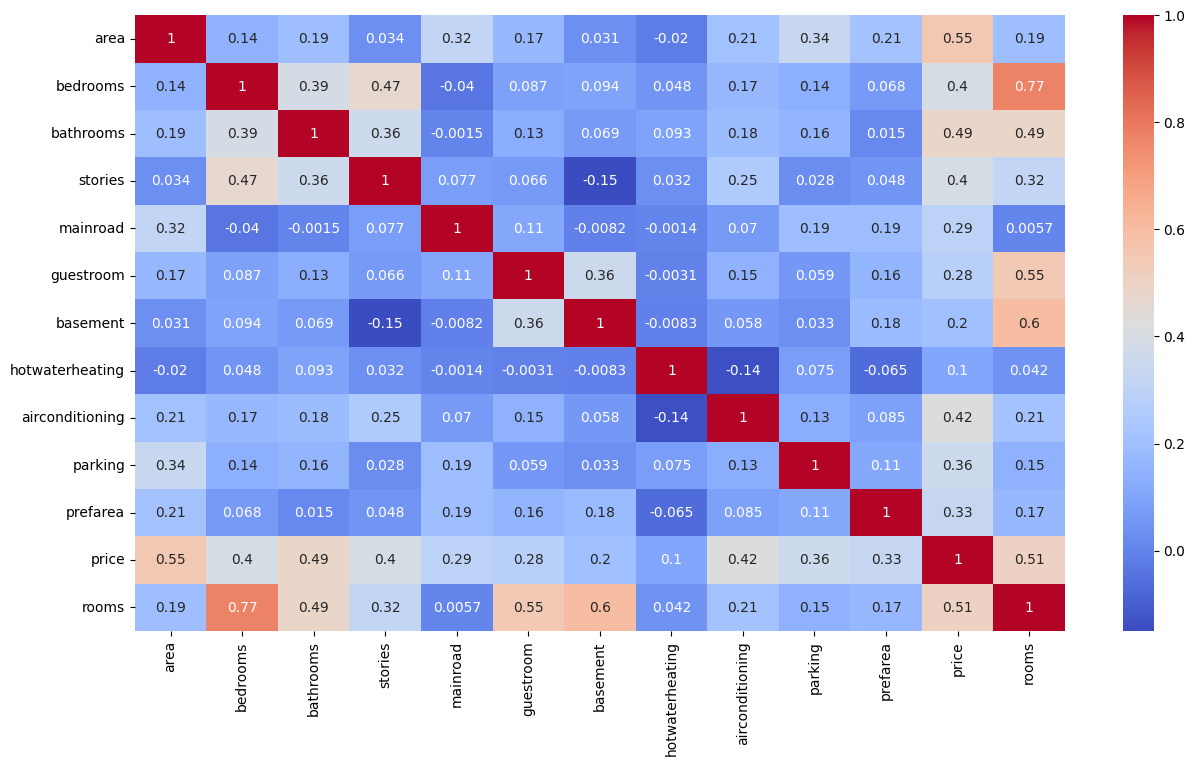

In [34]:
plt.figure(figsize=(15, 8))
sns.heatmap(train_data.drop("furnishingstatus", axis=1).corr(), annot=True, cmap='coolwarm')

In [41]:
train_data['furnishingstatus'] = train_data['furnishingstatus'].map({'furnished': 2, 'semi-furnished': 1, 'unfurnished': 0})


In [71]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train, y_train = train_data.drop(['price'], axis=1), train_data['price']
X_train_s = scaler.fit_transform(X_train)


reg = LinearRegression()
reg.fit(X_train_s, y_train)

LinearRegression()

In [50]:
test_data = X_test.join(y_test)
test_data = test_data.apply(lambda col: col.map({'yes': 1, 'no': 0}) if col.isin(['yes', 'no']).all() else col)


test_data['area'] = np.log(test_data['area'] + 1)
test_data['stories'] = np.log(test_data['stories'] + 1)
test_data['bathrooms'] = np.log(test_data['bathrooms'] + 1)
test_data['price'] = np.log(test_data['price'] + 1)

test_data['rooms'] = test_data['bedrooms'] + test_data['bathrooms'] + test_data['guestroom'] + test_data['basement']

In [72]:
X_test, y_test = test_data.drop(['price'], axis=1), test_data['price']

X_test_s = scaler.fit_transform(X_test)


In [73]:
reg.score(X_test_s, y_test)

0.7126184589828004

In [77]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor()
forest.fit(X_train_s, y_train)

RandomForestRegressor()

In [78]:
forest.score(X_test_s, y_test)

0.6972618699144002

In [94]:
from sklearn.model_selection import GridSearchCV

forest = RandomForestRegressor()

params = {
    "n_estimators": [3, 10, 30, 50, 100],
    "max_features": [1, 2, 3, 4, 5, 6, 8],
    "min_samples_split": [2, 4],
    "max_depth": [None, 4, 8]
}

grid_search = GridSearchCV(forest, params, cv=5, scoring="neg_mean_squared_error", return_train_score=True)
grid_search.fit(X_train_s, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None, 4, 8],
                         'max_features': [1, 2, 3, 4, 5, 6, 8],
                         'min_samples_split': [2, 4],
                         'n_estimators': [3, 10, 30, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [95]:
grid_search.best_estimator_

RandomForestRegressor(max_depth=8, max_features=2, min_samples_split=4)

In [97]:
best_forest = RandomForestRegressor(max_features=2, n_estimators=30, max_depth=8, min_samples_split=4)
best_forest.fit(X_train_s, y_train)

RandomForestRegressor(max_depth=8, max_features=2, min_samples_split=4,
                      n_estimators=30)

In [98]:
best_forest.score(X_test_s, y_test)

0.671380782598816